## Preparación de los datos

En [este tutorial](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0), se explica el procedimiento (en inglés).

Primero importamos las librerías y funciones que vamos a utilizar.

In [1]:
import torch #PyTorch
import torchvision 
#Libreria para procesar imágenes para ML
import numpy as np #Librería para hacer operaciones vectoriales y matriciales
import torch.nn as nn #Librería de torch con funciones para hacer cosas con redes neuronales
import torch.nn.functional as F #Lo mismo que nn pero le pasas los argumentos DENTRO de la funcion
import torchvision.transforms #Sirve para hacer transformaciones a la imágenes por ej rotaciones 
from torchvision.datasets import MNIST #Dataset que vamos a usar. Lo importamos desde PyTorch
from torch.utils.data.dataloader import DataLoader #Sirve para cargar los datos
from torch.utils.data import random_split #Sirve para partir listas de manera aleatoria

#Librerias para plotear
from torchvision.utils import make_grid #para hacer un ploteo con varias imagenes del dataset
import matplotlib.pyplot as plt
%matplotlib inline

Descargamos los datos y creamos un dataset de PyTorch. Los datos serán imágenes de 28x28 píxeles en blanco y negro (es decir, cada imágen será una matriz 28x28x1) de números escritos. Este famoso dset de datos se denomina `MNIST` y es una clase dentro de la librería `torchvision.datasets`, de donde lo descargaremos.

In [2]:
dataset = MNIST(root='data/', 
                download=True, 
                transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),#transforma la img a tensores (matrices)
                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]) #normaliza 
               )

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629401553/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Usamos la función `random_split` para separar el dataset (60000 imagenes) en dos:

Conjunto de entrenamiento(train): contendrá 80% del total de imagenes.

Conjunto de validacióno(val): contendrá el restante 20% del total de imagenes.

In [3]:
train_size = 48000
val_size = len(dataset)- train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(48000, 12000)

Creamos los 'PyTorch data loaders' para el cojunto de entrenamiento y validación. Básicamente son funciones que ya vienen incluidas en PyTorch mediante las cuales podremos ordenar los datos y realizar un entrenamiento en mini-batches (lotes) del tamaño que elijamos, entre otras funcionaliades. Por ejemplo:

- shuffle (bool): Sirve para indicar si queremos que los datos se reorganicen luego de cada epoca de corrida.
- num_workers (int, optional): Cuántos subprocesos usar para la carga de los datos. 0 significa que los datos se cargarán en el proceso principal. 
- pin_memory (bool, optional): Si está en True, el data loader va a copiar los Tensores en la memoria  CUDA antes de devoverlos. Sirve particularmente si vamos a usar el acelerador. 

Más documentación: https://pytorch.org/docs/stable/data.html

In [4]:
#Defino tamaño de los batch
batch_size=1000

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

Vamos a plotear un minibatch de imagenes. Para ello utilizamos la función `make_grid` de `torchvision` y el método `.permute`. Necesitamos este último porque la forma del tensor de las imágenes cargadas en el dataloader es [1,28,28], es decir que los canales están el la dimensión '0' del tensor (la primera). Pero la función `make_grid` toma como argumento tensores (imágenes) de la forma [ancho, alto, canales], por lo que si no hacemos este cambio con las dimensiones la funcion tira un error. Por lo tanto, con el método permute le pedimos que para cada tensor del dataloader, haga el siguiente cambio antes de pasarle en tensor a la función `make_grid`:

canales dim 0-> dim 2

ancho   dim 1-> dim 0

alto    dim2 -> dim 1


images.shape: torch.Size([1000, 1, 28, 28])




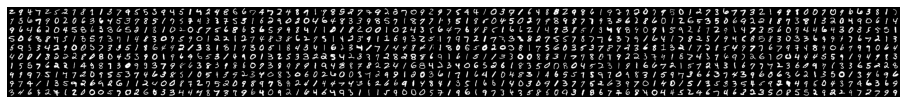

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=100).permute((1, 2, 0)))
    break

## Modelo

Antes que nada, vamos a definir la clase Flatten que simplemente usa la funcion view(input.size(0), -1) para 'aplastar' las imagenes, es decir convertir las matrices en un vector unidimensional. Podríamos usar directamente la función pero es mucho texto. Necesitamos hacer esto porque las funciones que vamos a usar en el modelo son lineales, toman vectores, osea tensores de dimension 1x(largo), no matrices.

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

flatten = Flatten()

In [8]:
#def accuracy(outputs, labels):
#    _, preds = torch.max(outputs, dim=1)
#    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#The accuracy we will define our own, that will be basically 
#the number of matched pixels (mask == prediction) divided by the total number of pixels in a batch
def accuracy(outputs, yb):
    return (outputs.argmax(dim=1) == yb).float().mean()

#correct += outputs.eq(target.data.view_as(outputs)).sum()

Ahora si, el modelo:

* Usaremos la función `nn.Linear`. Cada vez que usamos una de estas en la red, se dice que es una 'capa' de la misma.

* La primera capa (hidden layer) transformará la matriz de entrada, cuyo tamaño será `batch_size x 784`(luego de pasarla por Flatten) en una matriz intermedia de tamaño `batch_size x hidden_size`, donde `hidden_size` es un parámetro que le pasaremos de antemano a la función, el tamaño de la capa oculta.

* Luego le pasamos la salida de esta funcion a la función `Dropout(p).` Esto 'apaga' algunas conexiones de manera aleatoria, con una probabilidad p. Es un método que sirve para mejorar la performance del modelo. El tamaño se conserva.

* Luego le pasamos la salida a una función de activación no lineal, en particular elegiremos la ReLU(). 

* Al resultado que sale de la función activación, de tamaño `batch_size x hidden_size`, se lo pasamos a la segunda capa denominada 'output layer', que es la capa final y se ocupará de transformar la salida en una matriz de tamaño  `batch_size x 784` identico al tamaño de la entrada inicial, ya que de eso se trata el autoencoder.

In [9]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        #Dropuot
        self.drop = nn.Dropout(0.1)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        #droput 
        out = self.drop(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.mse_loss(out,flatten(images)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, flatten(images))   # Calculate loss ([1, 1, 28, 28])
        #acc = accuracy(out, images.view(-1, 784))          # Calculate accuracy
        return {'val_loss': loss} # val_acc acc
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        #batch_accs = [x['val_acc'] for x in outputs]
        #epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()} # 'val_acc': epoch_acc.item()
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

## Prueba
Crearemos un modelo que contenga una sola capa oculta con 512 activaciones; este no es el entrenamiento definitivo, sólo vamos a ver si el código funciona antes de entrenar.

In [10]:
input_size = 784
hidden_size = 512 # you can change this
out_size = 784

model = MnistModel(input_size, hidden_size=hidden_size, out_size=out_size)

Veamos si los tamaños de las salidas son los esperados. 

In [11]:
for t in model.parameters():
    print(t.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([784, 512])
torch.Size([784])


Generemos algunas salidas del modelo, para ver cómo funciona.

In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.mse_loss(outputs, flatten(images))
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
print('image shape in loader ', outputs[:2].data)

Loss: 1.075011134147644
outputs.shape :  torch.Size([1000, 784])
Sample outputs :
 tensor([[ 0.1288,  0.1462,  0.0905,  ..., -0.3094,  0.3004, -0.2052],
        [ 0.2076, -0.0621, -0.0820,  ..., -0.1715, -0.0393, -0.1204]])
image shape in loader  tensor([[ 0.1288,  0.1462,  0.0905,  ..., -0.3094,  0.3004, -0.2052],
        [ 0.2076, -0.0621, -0.0820,  ..., -0.1715, -0.0393, -0.1204]])


In [13]:
for xb, yb in val_loader:
    print('xb shape', xb.shape)
    print('yb shape', yb.shape)
    break

xb shape torch.Size([1000, 1, 28, 28])
yb shape torch.Size([1000])


## Training the Model

Vamos a definir algunas funciones que servirán para entrena el modelo. El entrenamiento se realizará con un learning rate variable a lo largo de los batches. Se podría hacer con un lr constante haciendo algunas modificacione en el código.

Más documentacion sobre [lr variables](http://https://pytorch.org/docs/stable/optim.html?highlight=one%20cycle#torch.optim.lr_scheduler.OneCycleLR)

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                 grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Con lo siguiente podremos ver cómo se desempeña el modelo con un conjunto inicial de pesos. Si vamos a entrenar definitivamente, recomiendo reiniciar el kerne y saltar este paso.

In [15]:
#history = [evaluate(model, val_loader)]
#history

Elegimos los parámetros con los que entrenaremos

In [16]:
epochs = 30
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-4
input_size = 784

Entrenaremos con diferentes tamaños de capas ocultas para después comparar con cuál se desempeña mejor el modelo.

In [17]:
hidden_size1 = 64 

model1 = MnistModel(input_size, hidden_size=hidden_size1, out_size=input_size)
to_device(model1, device)

history1 = [evaluate(model1, val_loader)]
history1

NameError: name 'to_device' is not defined

In [18]:
%%time
history1 += fit_one_cycle(epochs, max_lr, model1, train_loader, val_loader,grad_clip=grad_clip)

NameError: name 'history1' is not defined

In [19]:
hidden_size2 = 128

model2 = MnistModel(input_size, hidden_size=hidden_size2, out_size=input_size)
to_device(model2, device)

history2 = [evaluate(model2, val_loader)]
history2

NameError: name 'to_device' is not defined

In [20]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_loader, val_loader, grad_clip=grad_clip)

NameError: name 'history2' is not defined

In [21]:
hidden_size3 = 256

model3 = MnistModel(input_size, hidden_size=hidden_size3, out_size=input_size)
to_device(model3, device)

history3 = [evaluate(model3, val_loader)]
history3

NameError: name 'to_device' is not defined

In [22]:
%%time
history3 += fit_one_cycle(epochs, max_lr, model3, train_loader, val_loader, grad_clip=grad_clip)

NameError: name 'history3' is not defined

In [23]:
hidden_size4 = 512

model4 = MnistModel(input_size, hidden_size=hidden_size4, out_size=input_size)
to_device(model4, device)


history4 = [evaluate(model4, val_loader)]
history4

NameError: name 'to_device' is not defined

In [24]:
%%time
history4 += fit_one_cycle(epochs, max_lr, model4, train_loader, val_loader, grad_clip=grad_clip)

NameError: name 'history4' is not defined

## Ploteos

### Error cuadrático medio de val

In [25]:
vloss1 = [x['val_loss'] for x in history1]
vloss2 = [x['val_loss'] for x in history2]
vloss3 = [x['val_loss'] for x in history3]
vloss4 = [x['val_loss'] for x in history4]
plt.plot(vloss1, '-r.', label='64')
plt.plot(vloss2, '-b.', label='128')
plt.plot(vloss3, '-g.', label='256')
plt.plot(vloss4, '-m.', label='512')

plt.xlabel('epoca')
plt.ylabel('error')
plt.title('Error cuadrático medio - Test')
plt.legend(title='Tamaño capa oculta')

NameError: name 'history1' is not defined

### Error cuadrático medio de train

In [26]:
tloss1 = [x.get('train_loss') for x in history1]
tloss2 = [x.get('train_loss') for x in history2]
tloss3 = [x.get('train_loss') for x in history3]
tloss4 = [x.get('train_loss') for x in history4]
plt.plot(tloss1, '-r.', label='64')
plt.plot(tloss2, '-b.', label='128')
plt.plot(tloss3, '-g.', label='256')
plt.plot(tloss4, '-m.', label='512')

plt.xlabel('epoca')
plt.ylabel('error')
plt.title('Error cuadrático medio - Train')
plt.legend(title='Tamaño capa oculta')

NameError: name 'history1' is not defined

### Función de pérdida vs numero de epoca

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b.')
    plt.plot(val_losses, '-r.')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

### Learning rate vs batch

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history4)

NameError: name 'history4' is not defined

## Testeo
Con las siguientes funciones podremos graficar un autput del modelo junto con la imagen original, de forma que podamos comparar.

In [29]:
#Test
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)  # Convert to a batch of 1
    yb = model(xb) # Get predictions from model
    return yb

In [30]:
def plot_autoencoder_outputs(x_test, autoencoder, dims):
    decoded_imgs = predict_image(x_test,autoencoder).detach().numpy()

    # number of example digits to show
    #n = 5
    plt.figure(figsize=(10, 4.5))
    #for i in range(n):
        # plot original image
    ax = plt.subplot(2, 1,1)
    plt.imshow(x_test.reshape(*dims))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original Images')

        # plot reconstruction 
    ax = plt.subplot(2, 1,2)
    plt.imshow(decoded_imgs.reshape(*dims))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed Images')
    plt.show()

In [31]:
img_orig, label = val_ds[11235] #le pasamos el numero de imagen del set de validación

In [32]:
plt.figure()
plot_autoencoder_outputs(img_orig,model1,(28, 28))
plot_autoencoder_outputs(img_orig,model2,(28, 28))
plot_autoencoder_outputs(img_orig,model3,(28, 28))
plot_autoencoder_outputs(img_orig,model4,(28, 28))

NameError: name 'to_device' is not defined

<Figure size 432x288 with 0 Axes>

## Commit and upload the notebook

Finalemente, guardamos el trabajo en Jovian. Esto es muy util si queremos, además de conservar versiones, guardar las métricas de forma simple.

In [33]:
!pip install jovian --upgrade -q

import jovian

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

In [34]:
jovian.reset()

jovian.log_hyperparams(capa_oculta=hidden_size,
                       cant_epocas = epochs,
                       lr = max_lr,
                       grad_clip = grad_clip)

jovian.log_metrics(min_train_loss=,  min_val_loss= , time = ' ', lr_de_minLoss = )

jovian.commit(project='Autoencoder simple', outputs=['Autoencoder simple.pth'], environment=None)

SyntaxError: invalid syntax (<ipython-input-34-e2ddabaf10de>, line 8)

Fuentes:

[Pytorch: from zero to GANs](http://jovian.ai)

https://nextjournal.com/gkoehler/pytorch-mnist

https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%203%20-%20Autoencoders.ipynb